**Author:** Max Aragón (1)<br>
**Professor:** lucas.drumetz@imt-atlantique.fr (2)<br>
**Affiliations:** (1) Université Bretagne Sud and (2) IMT Atlantique<br>
**Course:** Machine Learning <br>
**Date:** 2022-11-20

<div class="alert alert-block alert-success">
<h2><center>Lab Session: Dimension reduction</center></h2>

The goal of this lab is to get familiar with the concept of dimension reduction and visualization for high-dimensional data using Principal Component Analysis on a real hyperspectral dataset.

The data is provided courtesy of Naoto Yokoya and Japan Space Systems (only for this lab, please do not distribute). See Matsuki, T., Yokoya, N., & Iwasaki, A. (2015). Hyperspectral tree species classification of Japanese complex mixed forest with the aid of LiDAR data. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 8(5), 2177-2187. for more details.

In [1007]:
import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, exposure
from sklearn.decomposition import PCA

In [1008]:
#os.chdir('/Users/max/Desktop/UBS/Data')

(207, 268)


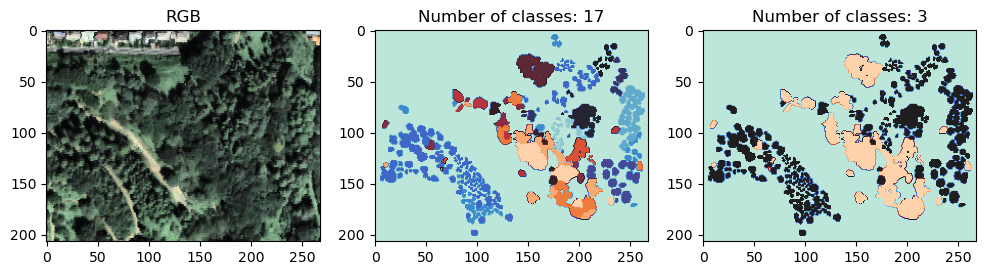

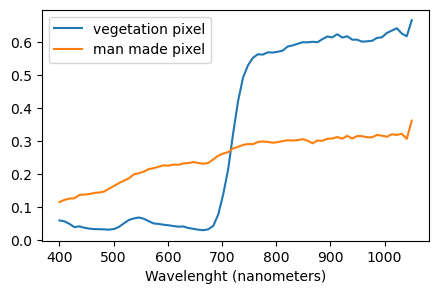

In [1009]:
data = sio.loadmat("CASI3_North.mat")
rgb_data = sio.loadmat("rgb.mat")
classinfo = sio.loadmat("GT_North.mat")

wavelengths = np.linspace(400,1050,72) # 72 wavelenghts in the visible and near IR

im = data['hyper'].astype("double")


im = (im - np.amin(im))/(np.amax(im) - np.amin(im)) # rescale data between 0 and 1

imrgb = rgb_data['rgb_adjust']

class_img = classinfo['class']

# get labels for both classes: conifer trees and broadleaf trees

binary_class_img = np.zeros(np.shape(class_img))

print(binary_class_img.shape)

binary_class_img[class_img <=9] = 1 # conifer
binary_class_img[class_img >9] = 2 # broadleaf
binary_class_img[class_img == 0] = 0 # unclassified


# display

plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(imrgb)
plt.title('RGB')

plt.subplot(132)
plt.imshow(class_img, cmap='icefire')
plt.title(f'Number of classes: {str(len(np.unique(class_img)))}')

plt.subplot(133)
plt.imshow(binary_class_img, cmap='icefire')
plt.title(f'Number of classes: {str(len(np.unique(binary_class_img)))}')

plt.figure(figsize=(5,3))
plt.plot(wavelengths, im[50,50,:], label='vegetation pixel') # one vegetation pixel
plt.plot(wavelengths, im[112,90,:], label = 'man made pixel' ) # one man made pixel
plt.xlabel('Wavelenght (nanometers)')
plt.legend()
plt.show()

**Q: What are the main broad classes of materials that are present in the image?**

Vegetation vs non-vegetation

(72, 7726)
(72, 4895)


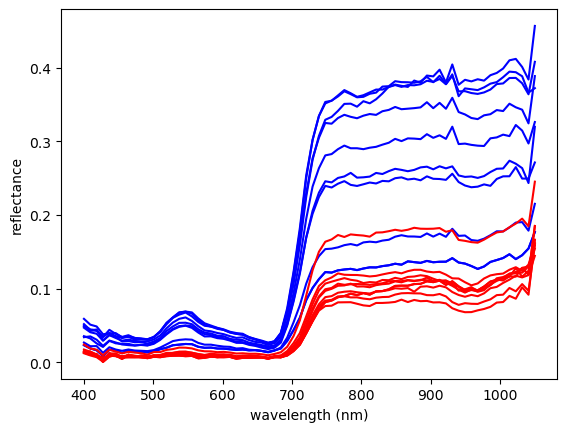

555.6338028169014
702.1126760563379


In [1010]:
conifer_pixels = im[binary_class_img == 1,:].T
print(conifer_pixels.shape)

broadleaf_pixels = im[binary_class_img == 2,:].T
print(broadleaf_pixels.shape)


plt.figure()
plt.plot(wavelengths,conifer_pixels[:,0:10], 'b')
plt.plot(wavelengths,broadleaf_pixels[:,0:10],'r')
plt.xlabel('wavelength (nm)')
plt.ylabel('reflectance')
plt.show()

print(wavelengths[17])
print(wavelengths[33])

**Q: What are the main differences between spectra of conifer and broadleaf trees?**

at first look, conifer trees exhibit higher reflectance than broadleaf trees at both, narrow (>700) and wide wavelenghts (<700)

**Q: First plot the mean value of the data (the mean spectrum over all pixels). Does it look more like a vegetation spectrum or the spectrum of some man-made material? Why?**

Evidently looks more like the typical vegetation red edge biosignature. The reason is due to the abundance of vegetation-like pixels.

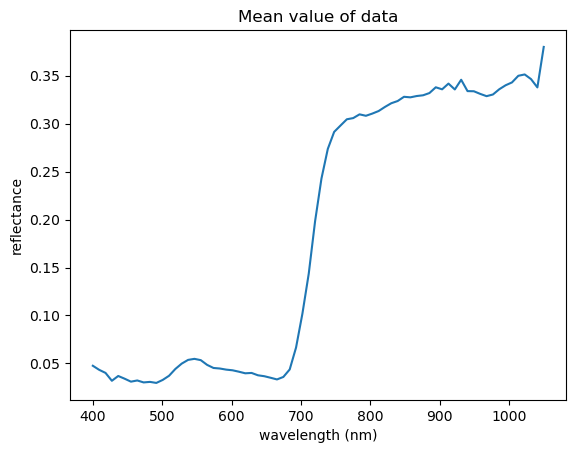

In [1011]:
unclassified_pixels = im[binary_class_img == 0,:].T
unclassified_mean = np.mean(unclassified_pixels, axis=1)

conifer_mean = np.mean(conifer_pixels, axis=1)
broadleaf_mean = np.mean(broadleaf_pixels, axis=1)

data_mean = conifer_mean+broadleaf_mean+unclassified_mean/3

plt.plot(wavelengths,unclassified_mean)
plt.title('Mean value of data')
plt.xlabel('wavelength (nm)')
plt.ylabel('reflectance')
plt.show()

## Visualize different channels

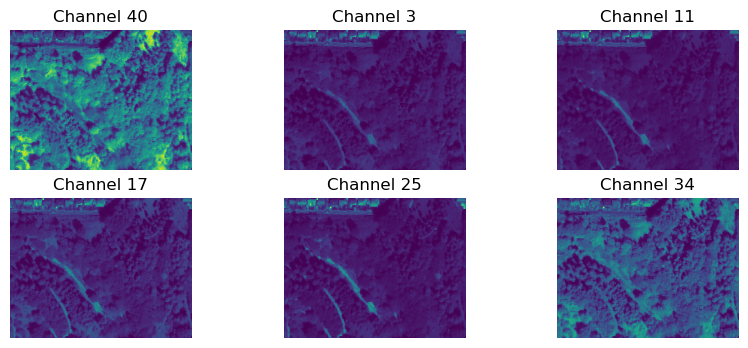

In [1012]:
fig = plt.figure(figsize =(10,4))

for i in range(1, 1+6):
    fig.add_subplot(2,3,i)
    v = np.random.randint(im.shape[2])
    plt.imshow(im[:,:,v])
    plt.axis('off')
    plt.title(f'Channel {v}')

We will use the built-in scikit learn functions to represent the principal components and the coefficients.

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

**Q: Use the PCA class to compute the decomposition, using pca.fit, with 72 components (all of them).\
Plot the eigenvalues, together with the explained variance as functions of the component number, you can recover them with pca.singular_values_ and pca.explained_variance_ratio_.**

**Similarly, use pca.components to recover the components, and plot them. What do they look like and what are their dimensions?** 

**Finally, compute the coefficients of the decomposition using pca.transform. What are their dimensions?**

**You can represent them as images, if you reshape them (use the function numpy.reshape for that).**

**Can you interpret some of the components using the coefficients as well as the components themselves (what do they represent)?**


## Data reshape to fit PCA

In [1013]:
#Reshape the data cube into a transposed matrix of size (Channels x Pixels)

height, width, channels = np.shape(im)
im_r = np.reshape(im,(height*width,channels)).T 

Channels, Pixels = im_r.shape
print(f'Number of channels: {Channels}')
print(f'Number of pixels: {Pixels}')

Number of channels: 72
Number of pixels: 55476


## Compute PCA

Steps to compute PCA

+ 1. Standardize the data
+ 2. Calculate the covariance matrix
+ 3. Find the eigenvalues and eigenvectors for that covariance matrix.
+ 4. Sort eigenvalues (argmax)
+ 5. Transform the original matrix (orthogonal projection)

In [384]:
# PCA components

# Compute the PCA

n_components = 72
pca = PCA(n_components=n_components)

# Fit PCA

pca.fit(im_r)

PCA(n_components=72)

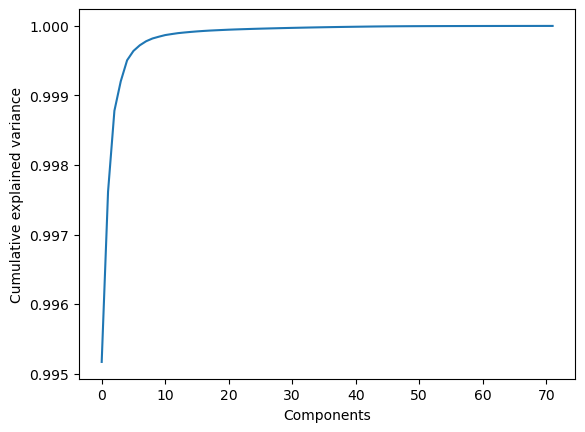

In [269]:
# display

cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumulative_explained_variance)
plt.ylabel('Cumulative explained variance')
plt.xlabel('Components')
plt.show()

## Eigenvalues in descending order.



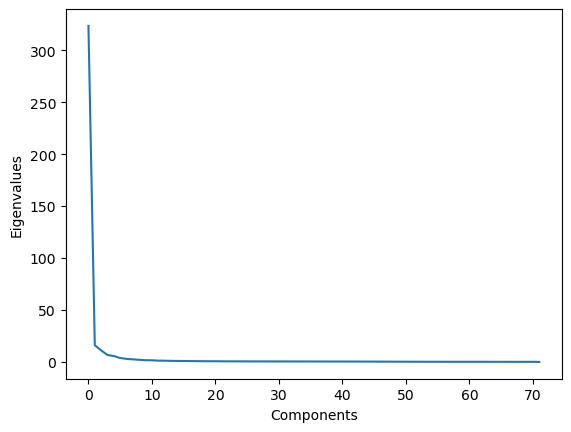

In [272]:
eigenvalues = pca.singular_values_

plt.plot(eigenvalues)
plt.ylabel('Eigenvalues')
plt.xlabel('Components')
plt.show()

## Components (eigenvectors)

In [297]:
components = pca.components_
components.shape

(72, 55476)

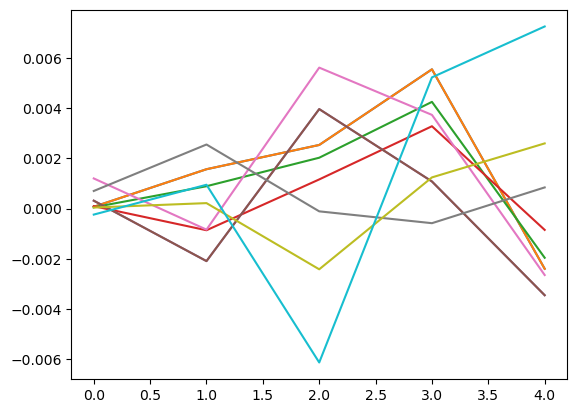

In [347]:
# display principal components and coefficients

plt.plot(components[:5,:10])
plt.show()

## Coefficients of decomposition

###  Coordinates of the points transformed on the main axes 

In [388]:
coefficients = pca.transform(im_r)
coefficients.shape

(72, 72)

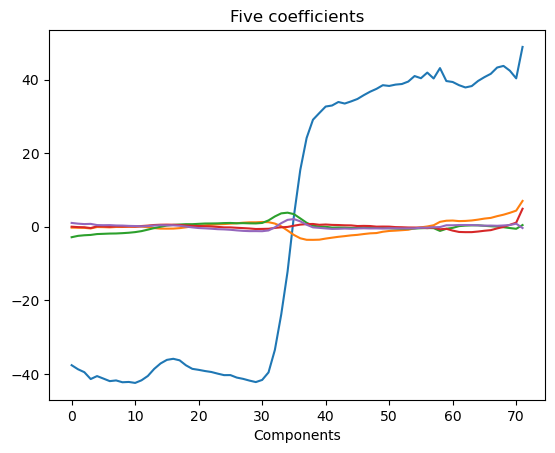

In [632]:
plt.plot(coefficients[:,0:5])
plt.title('Five coefficients')
plt.xlabel('Components')
plt.show()

In [363]:
# If 98% variance is needed, just one component is enough
#pca=PCA(0.98) 
#X_new=pca.fit_transform(im_r) 
#print(X_new.shape)

(72, 1)


In [365]:
# If 99.6% variance is needed, 2 components are required
#pca=PCA(0.996) 
#X_new=pca.fit_transform(im_r) 
#print(X_new.shape)

(72, 2)


**Q: Almost all the variance in the data is explained by only a few components: are they interpretable? What parts of the image do they explain, respectively?**

These are interpretable due to the nature of the image. For instance, the first component highlights the strong vegetation signal.

**Q: The dataset can be projected in the 2D latent space given by the first 2 principal components (each pixel is represented only by the first two coefficients of the PCA decomposition). Make a scatterplot of the data points in the space spanned by the first 2 eigenvectors. Can you locate vegetation pixels, and others?**

## Scatter plot (2 components)

In [434]:
import seaborn as sns
import pandas as pd

In [644]:
def pixels_classes(im, binary_class_img):
    q = im.reshape(-1, im.shape[2])
    df = pd.DataFrame(data = q)
    df = pd.concat([df, pd.DataFrame(data = binary_class_img.ravel())], axis=1)
    df.columns= [f'band{i}' for i in range(1, 1+im.shape[2])]+['class']
    df.to_csv('Dataset.csv')
    return df
  
df = pixels_classes(im, binary_class_img)

pca = PCA(n_components=2)
hyper_pca = pca.fit_transform(df.iloc[:,:-1].values)
pc_df = pd.DataFrame(data = hyper_pca, columns = ['PC1', 'PC2']); pc_df

PC1       PC2
0     -1.643940  0.171377
1     -1.643940  0.171377
2     -1.663371  0.161406
3     -1.452946  0.311915
4     -1.227615  0.412938
...         ...       ...
55471 -0.525026 -0.051135
55472 -0.020110 -0.012603
55473  0.402552  0.044921
55474 -0.882683 -0.082425
55475 -1.424056 -0.110715

[55476 rows x 2 columns]

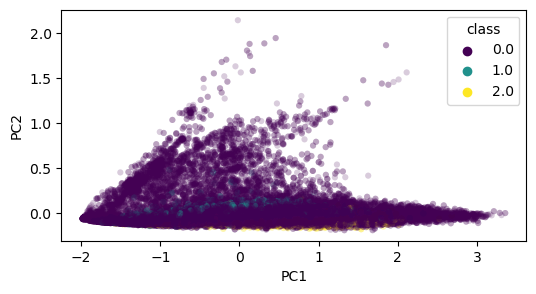

In [645]:
plt.figure(figsize=(6,3))
sns.scatterplot(x="PC1", y="PC2",data=pc_df, hue=df['class'], palette='viridis', edgecolor='none', alpha=0.2, s=20)
plt.title('')
plt.show()

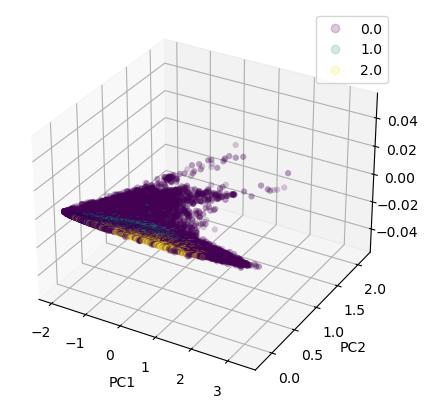

In [646]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')

s = ax.scatter(hyper_pca[:, 0], hyper_pca[:, 1], c=df['class'], cmap='viridis', edgecolor='none', alpha=0.2, s=20)
plt.legend(s.legend_elements()[0], list(set(df['class'])))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('')
plt.show()

Even with a 3D scatter plot is challenging to locate/separate pixels

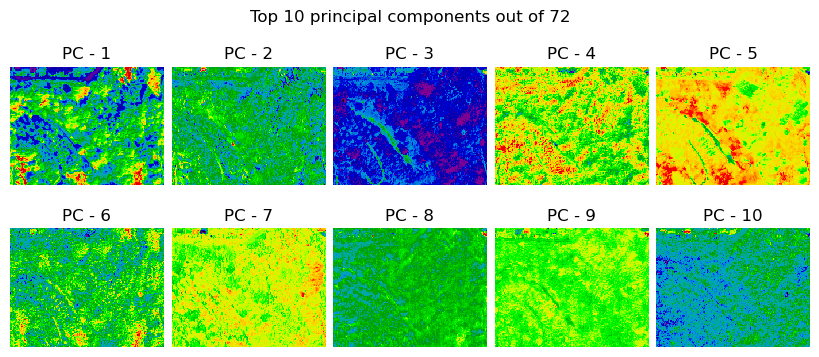

In [694]:
n_components = 72
pca = PCA(n_components=n_components)
x_pca = pca.fit_transform(im_r)

fig = plt.figure(figsize=(8,8)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
fig.suptitle('Top 10 principal components out of 72', y=1.05)
for i in range(10): 
    fig.add_subplot(5, 5, i+1) 
    plt.imshow(np.reshape(pca.components_[i,:], (207, 268)), cmap='nipy_spectral', interpolation='nearest') 
    plt.axis('off')
    plt.title(f'PC - {i+1}')

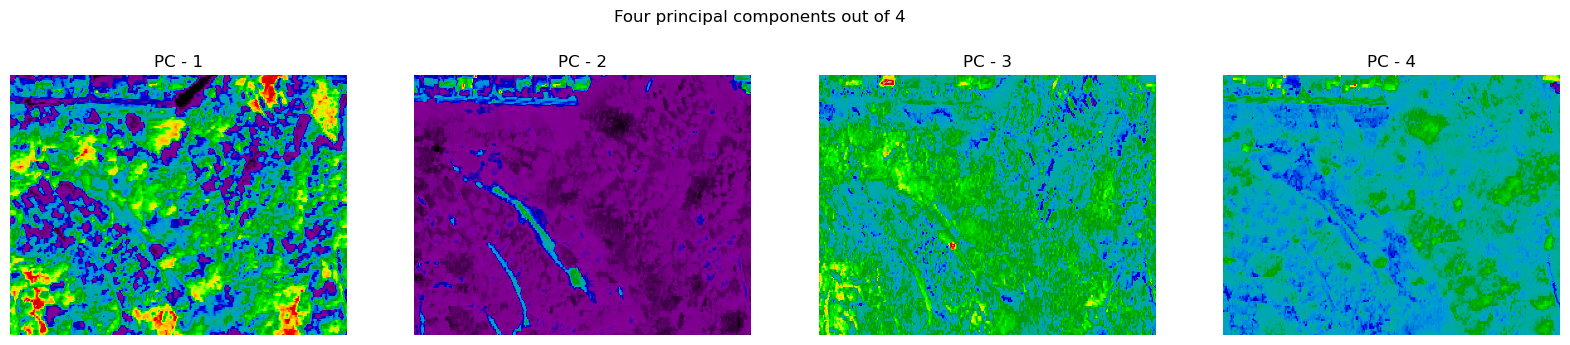

In [695]:
pca = PCA(n_components = 4)
dt = pca.fit_transform(df.iloc[:, :-1].values)
pca_df = pd.concat([pd.DataFrame(data = dt), pd.DataFrame(data = binary_class_img.ravel())], axis = 1)
pca_df.columns = [f'PC-{i}' for i in range(1,5)]+['class']

fig = plt.figure(figsize = (20, 10))
fig.suptitle('Four principal components out of 4', y=0.90)

for i in range(1, 1+4):
    fig.add_subplot(2,4, i)
    plt.imshow(pca_df.loc[:, f'PC-{i}'].values.reshape(207, 268), cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'PC - {i}')

## Image reconstruction 

**Q: Reconstruct the image using 1,2,5,10 and 72 components. Visually assess and describe in each case how well the data is reconstructed (e.g. by comparing the reconstructed rgb image with the true one, or plotting reconstructed spectra). Compute the mean absolute error in each pixel in each case**

The reconstruction for all data points using K components can be obtained by computing:
\begin{equation*}
\hat{\mathbf{X}} = \bar{\mathbf{X}} + \mathbf{U}_{K}\mathbf{A}_{K} 
\end{equation*}
where $\hat{\mathbf{X}}\in\mathbb{R}^{D\times N}$, and  $\mathbf{U}\in \mathbb{R}^{D\times K}$, and $\mathbf{A}^{K\times N}$. $\bar{\mathbf{X}}\in\mathbb{R}^{D\times N}$ is  a matrix containing the mean of the data in each column.

PCA reconstruction=PC scores⋅Eigenvectors⊤+Mean

In [1003]:
n_components = 72
pca = PCA(n_components=n_components)
pca.fit(im_r)

eigenvectors = pca.components_

scores = pca.transform(im_r)

mean = pca.mean_

print(eigenvectors.shape)
print(scores.shape)
print(mean.shape)

(72, 55476)
(72, 72)
(55476,)


In [1004]:
from skimage import color, exposure

def enhance_brightness_rgb(rgb_original):
    yuv= color.rgb2yuv(rgb_original) # change color space to radiance, chrominance
    p_low, p_high = np.percentile(yuv[:,:,0], (0.1,99.9)) # saturate outlier values in radiance (0.1,99.9)
    yuv[:,:,0] = exposure.rescale_intensity(yuv[:,:,0], in_range=(p_low, p_high)) # rescale radiance
    mod_rgb =  color.yuv2rgb(yuv) # transform back to rgb space
    return mod_rgb

Absolute difference for PC 1 in 72 channel image: 0.007095951958399756
Absolute difference for PC 2 in 72 channel image: 0.004902316082259038
Absolute difference for PC 5 in 72 channel image: 0.0023605758397223613
Absolute difference for PC 10 in 72 channel image: 0.001374989507161268
Absolute difference for PC 50 in 72 channel image: 0.00016682949243143697


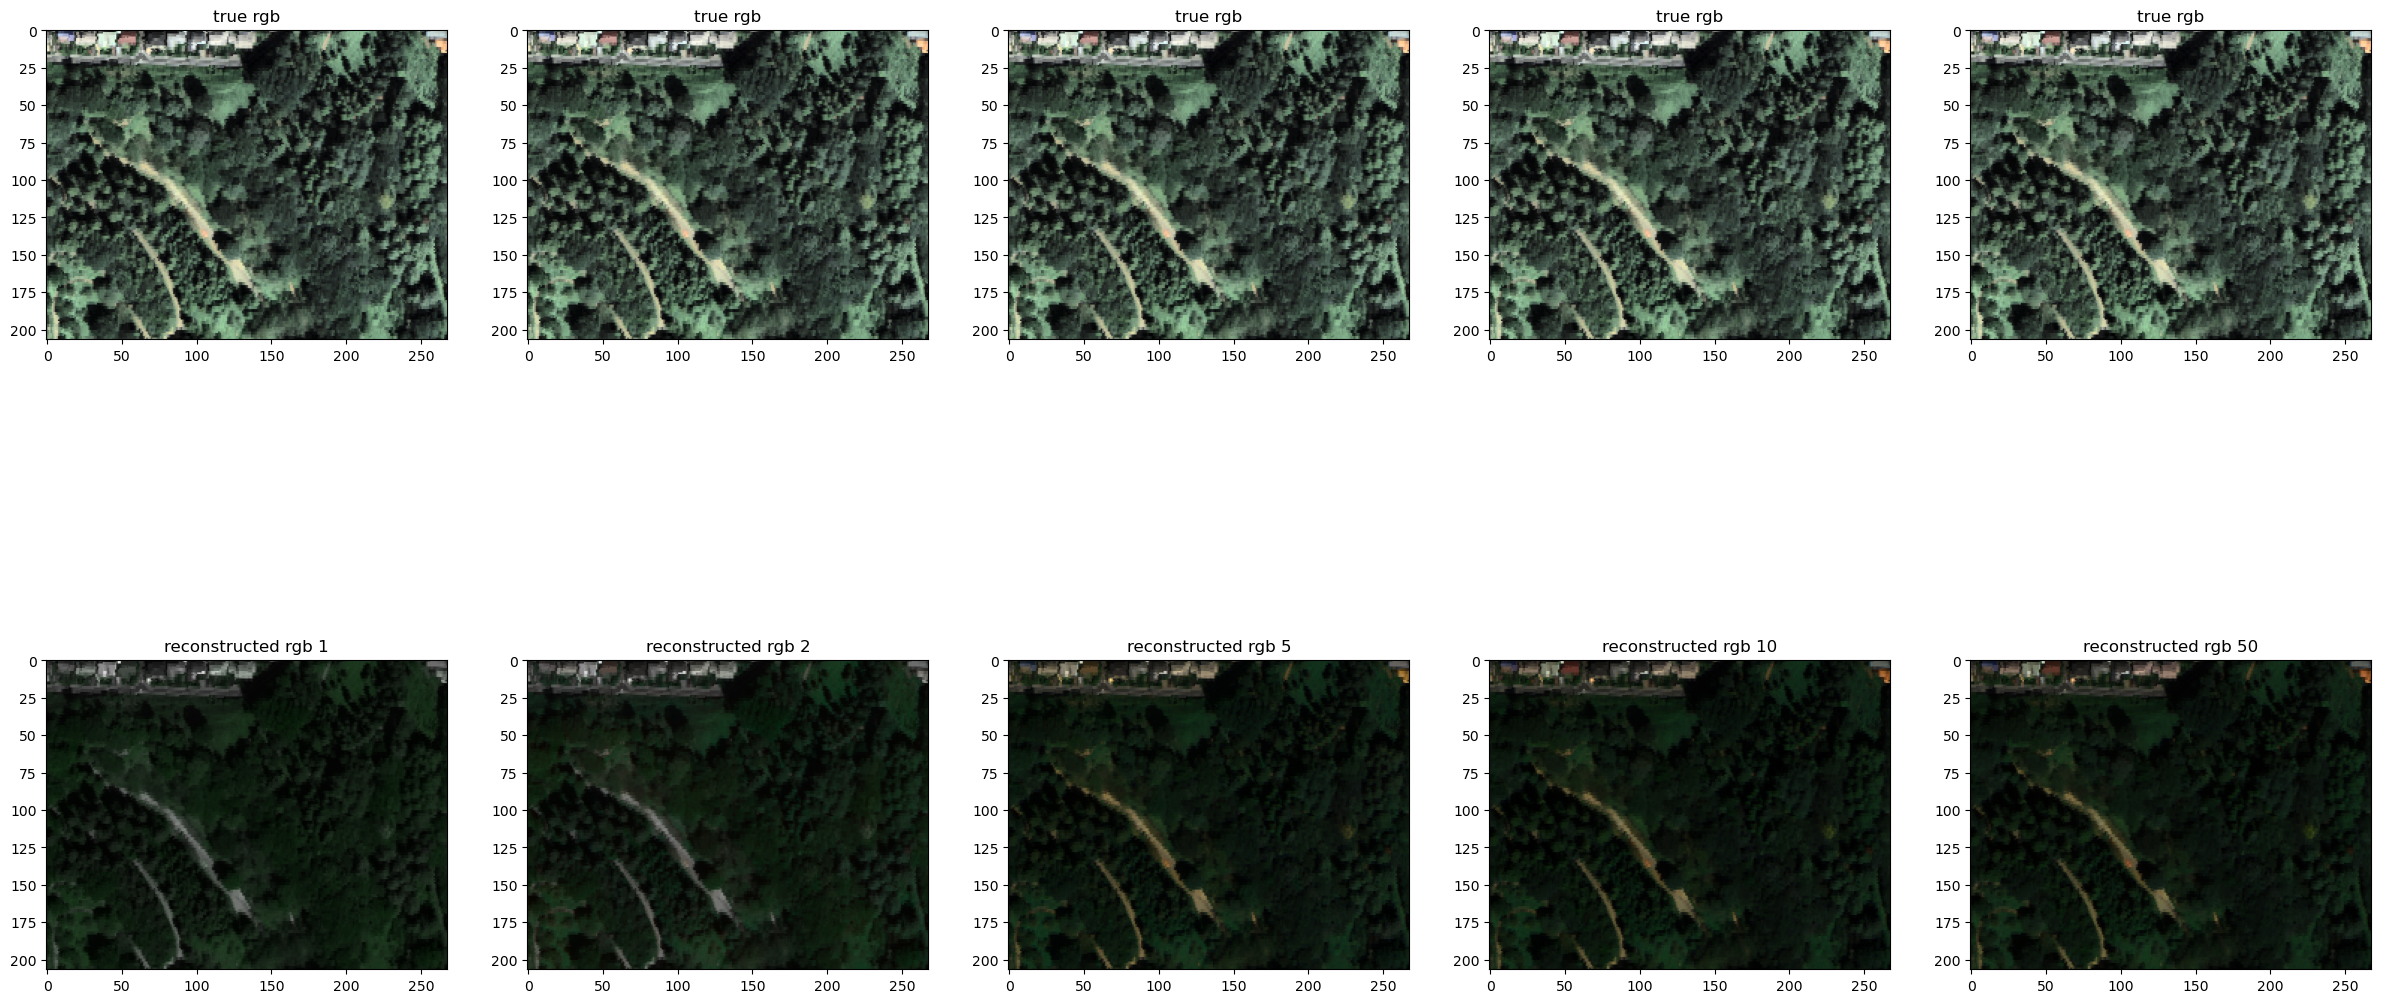

In [1035]:
from sklearn.metrics import mean_absolute_error as mae

PC = [1,2,5,10,50]

plt.figure(figsize =(30,15))

for i in range(len(PC)):
    reconstructed_image = scores[:,:PC[i]]@eigenvectors[:PC[i],:] + mean
    rec_im = np.reshape(reconstructed_image.T,(height, width,channels))

    # absolute difference
    error = mae(im_r, reconstructed_image)
    print('Absolute difference for PC {} in 72 channel image: {}'.format(PC[i],error))

    plt.subplot(2,len(k),len(PC)+i+1)
    rec_rgb = rec_im[:,:,[29,18,6]]
    rec_rgb = (rec_rgb - np.amin(rec_rgb))/(np.amax(rec_rgb) - np.amin(rec_rgb))
    plt.imshow(rec_rgb)
    plt.title(f'reconstructed rgb {PC[i]}')

    plt.subplot(2,len(PC),i+1)
    plt.imshow(imrgb)
    plt.title('true rgb')

Absolute difference for 2 PC  in 72 channel image: 0.004902316082259038


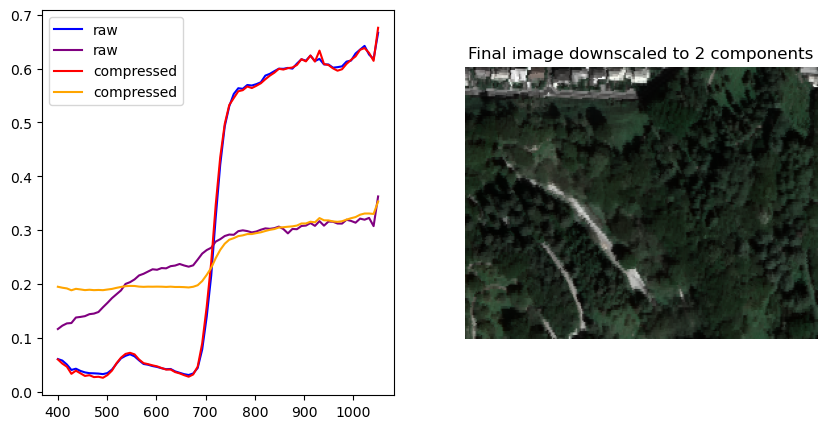

In [1132]:
# keep 2 components
    
final_nbr = 2


# pixel reconstruction

reconstructed_image_final = scores[:,:final_nbr]@eigenvectors[:final_nbr,:] + mean
rec_im = np.reshape(reconstructed_image_final.T,(height, width,channels))

rec_rgb = rec_im[:,:,[29,18,6]]
rec_rgb_final = (rec_rgb - np.amin(rec_rgb))/(np.amax(rec_rgb) - np.amin(rec_rgb))

rec_rgb_final = enhance_brightness_rgb(rec_rgb_final)
rec_rgb_enh = (rec_rgb_final - np.amin(rec_rgb_final))/(np.amax(rec_rgb_final) - np.amin(rec_rgb_final))

# absolute difference

error = mae(im_r, reconstructed_image_final)
print('Absolute difference for {} PC  in 72 channel image: {}'.format(final_nbr,error))

# visualizsation
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(wavelengths, im[50,50,:], label='raw', color='b')
plt.plot(wavelengths, im[112,90,:], label='raw', color='purple')
plt.plot(wavelengths, rec_im[50,50,:], label='compressed', color='r') # one vegetation pixel
plt.plot(wavelengths, rec_im[112,90,:], label='compressed', color='orange') # one man made pixel
plt.legend()
plt.subplot(1,2,2)
plt.title('Final image downscaled to 2 components')
plt.axis('off')
plt.imshow(rec_rgb_enh)
plt.show()



**Q: Finally, take a look at the last components and the associated coefficients. Are the components easy to interpret? How about the coefficients: what do they look like? Is it worth it to keep all the components (give 2 reasons why or why not)**

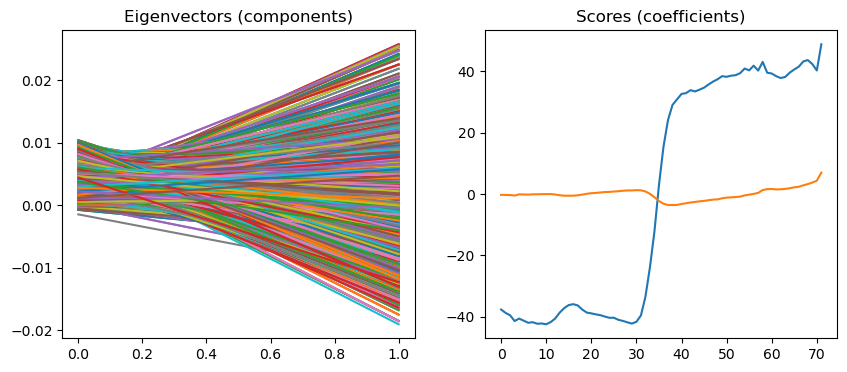

In [1102]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

eigenvectors = pca.components_
scores = pca.transform(im_r)

ax1.plot(eigenvectors[0:2,:])
ax1.set_title('Eigenvectors (components)')

ax2.plot(scores[:,0:2])
ax2.set_title('Scores (coefficients)')

plt.show()

Not worth to keep all the components, in fact, one components is capable of explaining 99.6% of the variance. However, by considering only 2 components some information is lost concerning mand-made pixels. Thus, I would perhaps keep, 3 or 4 components to maximize the variance. 

**Q: Bonus: Now perform a new PCA decomposition using only as a dataset the set of labeled pixels. Plot the dataset in the 2D space spanned by the first two components. What can you say about the new components and the separability of both classes rather than in the PCA space of the whole dataset?**

In [1127]:
conifer_pixels = im[binary_class_img == 1,:].T
broadleaf_pixels = im[binary_class_img == 2,:].T

new_data = np.concatenate((conifer_pixels,broadleaf_pixels),axis = 1)

# Compute PCA

n_components = 72
class_pca = PCA(n_components=n_components)
classes_pca = class_pca.fit_transform(new_data.T)

In [1125]:
labels = df[df['class']!=0]

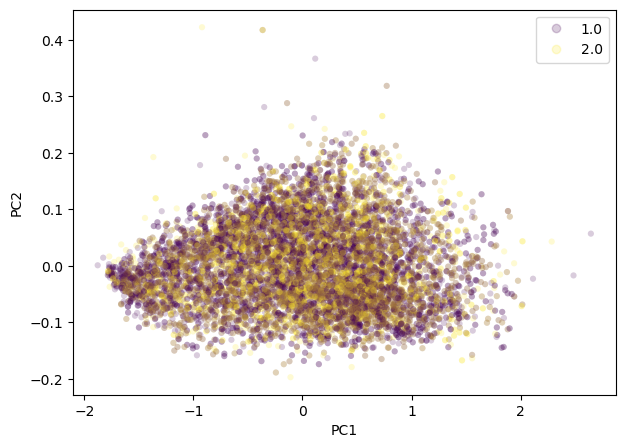

In [1131]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)

s = ax.scatter(classes_pca[:, 0], classes_pca[:, 1], c=binary_class_img[class_img !=0], cmap='viridis', edgecolor='none', alpha=0.2, s=20)
plt.legend(s.legend_elements()[0], list(set(labels['class'])))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('')
plt.show()

Data separability is not trivial. By removing the noise from unclassified pixels the vegetation classes are now visible. However, it remains challenging to classify them correctly.  